# Prerequirements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import cv2
import glob
import imgaug.augmenters as iaa
import imgaug as ia
import datetime

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Layer, ReLU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from tensorboard.plugins.hparams import api as hp

import warnings
warnings.filterwarnings("ignore")

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-17 10:37:20.727654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 10:37:20.822885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 10:37:20.823788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
def imshow(img: np.array):
    if img.shape[0] * 2 > img.shape[1]:
        fig = plt.figure(figsize=(7, 7))
    else:
        fig = plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(img)

In [4]:
! mkdir ./tensorboard/
! mkdir ./tensorboard/autoencoder/
! mkdir ./tensorboard/autoencoder/fit/
! mkdir ./tensorboard/autoencoder/hparam_tuning/
! mkdir ./models/
! mkdir ./models/autoencoder/
! mkdir ./images/
! mkdir ./images/autoencoder/

# Preparing dataset

In [5]:
# ds = []
# for idx, file in enumerate(glob.glob("/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/*")):
#     ds.append(np.array(PIL.Image.open(file).resize((112, 96))))
#     if idx >= 10001: break
# ds = np.array(ds)
# ds.shape

In [6]:
# idxs = np.random.choice(len(ds), 5)
# imshow(np.concatenate(ds[idxs], 1))

In [7]:
# def create_line_mask(img):
#     mask = np.full(img.shape, 255, np.uint8)
#     for _ in range(np.random.randint(6, 10)):
#         x1, x2 = np.random.randint(1, img.shape[1]), np.random.randint(1, img.shape[1])
#         y1, y2 = np.random.randint(1, img.shape[0]), np.random.randint(1, img.shape[0])
#         thickness = np.random.randint(4, 6)
#         cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

#     masked_image = cv2.bitwise_and(img, mask)

#     return masked_image

In [8]:
# idxs = np.random.choice(len(ds), 5)
# masked = np.array(list(map(create_line_mask, ds[idxs])))
# imshow(np.concatenate(masked, 1))

In [9]:
# for idx, sample in enumerate(ds):
#     PIL.Image.fromarray(sample).save(f'./data/samples/{idx}.png')
#     PIL.Image.fromarray(create_line_mask(sample)).save(f'./data/samples_line_masked/{idx}.png')
#     PIL.Image.fromarray(create_line_mask(sample)).save(f'./data/samples_square_masked/{idx}.png')

# Custom generator

In [10]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, X, Y, batch_size=128, dim=(112, 96), n_channels=3): 
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels

        self.on_epoch_end()
        assert(len(self.X) == len(self.Y) or len(self.X) > 0)

        
    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]
        return self.__data_generation(indexes)

    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
    

    def __data_generation(self, idxs):
        X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
        Y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))

        for i, idx in enumerate(idxs):
            image = np.array(PIL.Image.open(self.X[idx]))
            label = np.array(PIL.Image.open(self.Y[idx]))
            if np.random.randint(0, 100) < 20:
                X_batch[i,] = self.augment(image / 255)
                Y_batch[i,] = self.augment(label / 255)
            else:
                X_batch[i,] = image / 255
                Y_batch[i,] = label / 255

        return X_batch, Y_batch

    
    def augment(self, img):
        seq = iaa.Sequential([
            iaa.Sometimes(0.1, iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)))
        ])
        return seq(images=img)

In [11]:
def train_test_split(X, Y, train_size=0.8):   
    train_split = int(train_size * len(X))
    
    X_train = X[:train_split]
    Y_train = Y[:train_split]
    
    X_test = X[train_split:]
    Y_test = Y[train_split:]
    
    return X_train, X_test, Y_train, Y_test

In [12]:
X = sorted(glob.glob("/kaggle/input/cv-project3/data/samples_masked/*.png"))[:10001]
Y = sorted(glob.glob("/kaggle/input/cv-project3/data/samples/*.png"))[:10001]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [13]:
train_gen = DataGenerator(X_train, Y_train)
test_gen = DataGenerator(X_test, Y_test)

# Metrics

In [14]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f + y_pred_f))

In [15]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [16]:
cosine_similarity = tf.keras.metrics.CosineSimilarity(axis=1)

2023-01-17 10:37:30.232656: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 10:37:30.233177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 10:37:30.234132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 10:37:30.234821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# Autoencoder

In [17]:
class Autoencoder(keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()


    def __ConvBlock(self, out, kernel_size, prev_layer):
        cnn = Conv2D(out, kernel_size, padding="same")(prev_layer)
        cnn = BatchNormalization()(cnn)
        cnn = ReLU()(cnn)
        return cnn

    def __EncodeBlock(self, out, kernel_size, prev_layer, dr_rate=0.1):
        conv = self.__ConvBlock(out, kernel_size, prev_layer)
        conv = self.__ConvBlock(out, kernel_size, conv)
        conv = self.__ConvBlock(out, kernel_size, conv)
        conv = MaxPooling2D((2, 2))(conv)
        conv = Dropout(dr_rate)(conv)
        return conv


    def __DecodeBlock(self, out, kernel_size, prev_layer):
        up = Conv2DTranspose(out, kernel_size, strides=(2, 2), padding="same")(prev_layer)
        up = BatchNormalization()(up)
        up = ReLU()(up)
        return up


    def model(self, input_shape=(112, 96, 3), dr_rate=0.1, kernel_size=(3, 3)):
        inputs = keras.layers.Input(input_shape)

        conv1 = self.__EncodeBlock(32, kernel_size, inputs, dr_rate) 
        conv2 = self.__EncodeBlock(64, kernel_size, conv1, dr_rate)
        conv3 = self.__EncodeBlock(128, kernel_size, conv2, dr_rate) 
        conv4 = self.__EncodeBlock(256, kernel_size, conv3, dr_rate) 

        deconv1 = self.__DecodeBlock(256, kernel_size, conv4)
        deconv2 = self.__DecodeBlock(128, kernel_size, deconv1)
        deconv3 = self.__DecodeBlock(64, kernel_size, deconv2)
        deconv4 = self.__DecodeBlock(32, kernel_size, deconv3)

        outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(deconv4)

        return keras.models.Model(inputs=[inputs], outputs=[outputs])

## Parameters tuning on small part of dataset

In [18]:
# HP_DROPOUT = hp.HParam("dropout", hp.Discrete([0.1, 0.2, 0.3, 0.5]))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'adagrad']))

# METRIC = 'mean_absolute_error'

# with tf.summary.create_file_writer('./tensorboard/autoencoder/hparam_tuning').as_default():
#     hp.hparams_config(
#         hparams=[HP_DROPOUT, HP_OPTIMIZER],
#         metrics=[hp.Metric(METRIC, display_name='mean_absolute_error')]
#     )

In [19]:
# def train_test_model(hparams):
#     model = Autoencoder().model(input_shape=(112, 96, 3), dr_rate=hparams[HP_DROPOUT])
#     model.compile(
#         optimizer=hparams[HP_OPTIMIZER],
#         loss='mean_absolute_error',
#     )

#     history = model.fit(
#         train_gen, 
#         validation_data = test_gen, 
#         epochs=10, 
#         steps_per_epoch = len(train_gen), 
#         validation_steps = len(test_gen),
#         use_multiprocessing = True,
#     )
    
#     loss = model.evaluate(test_gen[0][0], test_gen[0][1])
#     return loss

In [20]:
# def run(run_dir, hparams):
#     with tf.summary.create_file_writer(run_dir).as_default():
#         hp.hparams(hparams)
#         loss = train_test_model(hparams)
#         tf.summary.scalar(METRIC, loss, step=1)

In [21]:
# session_num = 0

# for dr_rate in HP_DROPOUT.domain.values:
#     for optimizer in HP_OPTIMIZER.domain.values:
#         hparams = {
#             HP_DROPOUT: dr_rate,
#             HP_OPTIMIZER: optimizer,
#         }
#         run_name = "run-%d" % session_num
#         print('--- Starting trial: %s' % run_name)
#         print({h.name: hparams[h] for h in hparams})
#         run('logs/hparam_tuning/' + run_name, hparams)
#         session_num += 1

## Model training

In [22]:
model = Autoencoder().model(input_shape=(112, 96, 3), dr_rate=0.2)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef, jaccard_distance, cosine_similarity])
keras.utils.plot_model(model, show_shapes=True, to_file='./autoencoder.png')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    restore_best_weights=True
)

In [23]:
log_dir = "./tensorboard/autoencoder/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2023-01-17 10:37:34.408747: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-17 10:37:34.408793: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-17 10:37:34.410653: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2023-01-17 10:37:34.634866: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-17 10:37:34.635052: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [24]:
history = model.fit(
    train_gen, 
    validation_data = test_gen, 
    epochs=500, 
    steps_per_epoch = len(train_gen), 
    validation_steps = len(test_gen),
    use_multiprocessing = True,
    callbacks=[tensorboard_callback]
)

2023-01-17 10:37:36.655748: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2023-01-17 10:37:41.648341: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/31 [..............................] - ETA: 6:05 - loss: 0.2913 - dice_coef: 0.4969 - jaccard_distance: 1.4389 - cosine_similarity: 0.8322

2023-01-17 10:37:48.980192: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-17 10:37:48.980395: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/31 [>.............................] - ETA: 25s - loss: 0.2725 - dice_coef: 0.4933 - jaccard_distance: 1.4259 - cosine_similarity: 0.8443 

2023-01-17 10:37:49.734401: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-17 10:37:49.735836: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-17 10:37:49.878736: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 622 callback api events and 617 activity events. 
2023-01-17 10:37:49.898578: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-17 10:37:49.924730: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./tensorboard/autoencoder/fit/20230117-103734/train/plugins/profile/2023_01_17_10_37_49

2023-01-17 10:37:49.939924: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./tensorboard/autoencoder/fit/20230117-103734/train/plugins/profile/2023_01_17_10_37_49/40c671fa3195.trace.json.gz
2023-01-17 10:37:49.989464: I tensorflow

31/31 [==============================] - 79s 2s/step - loss: 0.1489 - dice_coef: 0.5762 - jaccard_distance: 1.1124 - cosine_similarity: 0.9143 - val_loss: 0.2398 - val_dice_coef: 0.4525 - val_jaccard_distance: 1.3950 - val_cosine_similarity: 0.8766
Epoch 2/500
31/31 [==============================] - 25s 794ms/step - loss: 0.0980 - dice_coef: 0.6109 - jaccard_distance: 1.0020 - cosine_similarity: 0.9503 - val_loss: 0.1990 - val_dice_coef: 0.4859 - val_jaccard_distance: 1.2987 - val_cosine_similarity: 0.9013
Epoch 3/500
31/31 [==============================] - 24s 756ms/step - loss: 0.0893 - dice_coef: 0.6158 - jaccard_distance: 0.9920 - cosine_similarity: 0.9568 - val_loss: 0.1956 - val_dice_coef: 0.4547 - val_jaccard_distance: 1.2600 - val_cosine_similarity: 0.9079
Epoch 4/500
31/31 [==============================] - 24s 744ms/step - loss: 0.0855 - dice_coef: 0.6175 - jaccard_distance: 0.9849 - cosine_similarity: 0.9592 - val_loss: 0.2035 - val_dice_coef: 0.4378 - val_jaccard_distance

In [25]:
model.save("./models/autoencoder/")

2023-01-17 15:36:37.780695: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


TypeError: Cannot handle this data type: (1, 1, 3), <f8

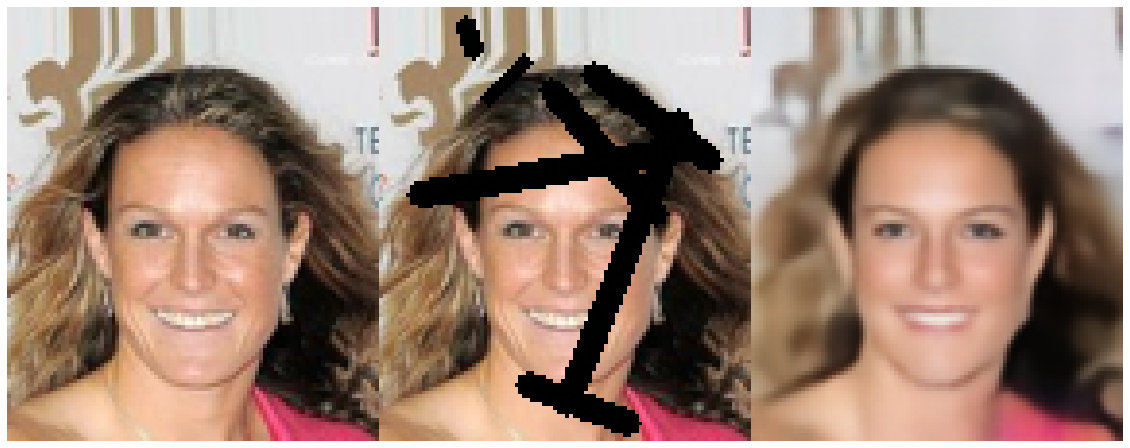

In [26]:
for i in range(10):
    gr_tr = test_gen[1][1][i]
    pred = model.predict(np.array([test_gen[1][0][i]])).reshape(112, 96, 3)
    res = np.concatenate([gr_tr, test_gen[1][0][i], pred], axis=1)
    imshow(res)
    im = PIL.Image.fromarray(res)
    im.save(f"./images/autoencoder/{i}.png")

In [ ]:
# class inpaintingModel:
#   '''
#   Build UNET like model for image inpaining task.
#   '''
#   def prepare_model(self, input_size=(208, 176, 3)):
#     inputs = keras.layers.Input(input_size)

#     conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
#     conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
#     conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
#     conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
#     conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
#     conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
#     conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
#     conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
#     conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
#     outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

#     return keras.models.Model(inputs=[inputs], outputs=[outputs])  

#   def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
#     conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
#     conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
#     if pool_layer:
#       pool = keras.layers.MaxPooling2D(pool_size)(conv)
#       return conv, pool
#     else:
#       return conv

#   def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
#     conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
#     conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
#     up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
#     up = keras.layers.concatenate([up, shared_layer], axis=3)

#     return conv, up

In [ ]:
# model = inpaintingModel().prepare_model(input_size=(208, 176, 3))
# model.compile(optimizer='adam', loss='mean_absolute_error')

# history = model.fit(train_gen, 
#           validation_data=test_gen, 
#           epochs=20, 
#           steps_per_epoch=len(train_gen), 
#           validation_steps=len(test_gen),
#           use_multiprocessing=True)

In [ ]:
# plt.imshow(model.predict(np.array([test_gen[1][0][61]])).reshape(208, 176, 3))